## Convert a boolian expression to an oracle

In [78]:
from qiskit.circuit import Parameter, ClassicalRegister
from funcs import *

### 1. convert expression to reverse prefix notation

In [79]:
# expression should only contain capital letters or !, (, ), &, separated by spaces
expression = '! ( ! ( A & B ) ) & ( ! C & D ) & E'

In [80]:
def infixToPostfix(infixexpr):
    prec = {}
    prec["!"] = 3
    prec["&"] = 2
    prec["("] = 1
    oplist = []
    postfixList = []
    tokenList = infixexpr.split()

    for token in tokenList:
        if token in "ABCDEFGHIJKLMNOPQRSTUVWXYZ" or token in "01":
            postfixList.append(token)
        elif token == '(':
            oplist.append(token)
        elif token == ')':
            topToken = oplist.pop()
            while topToken != '(':
                postfixList.append(topToken)
                topToken = oplist.pop()
        else:
            while (len(oplist)>0) and \
               (prec[oplist[-1]] >= prec[token]):
                  postfixList.append(oplist.pop())
            oplist.append(token)

    while len(oplist) > 0:
        postfixList.append(oplist.pop())
    return " ".join(postfixList)

rpn = infixToPostfix(expression)
rpnlst = rpn.split()
print(rpnlst)

['A', 'B', '&', '!', '!', 'C', '!', 'D', '&', '&', 'E', '&']


### 2.Convert RPN to qiskit instructions

In [81]:
qubit_num = len(rpnlst) - rpnlst.count('!')
qc = QuantumCircuit(qubit_num)
qubit_dict = {}
flag = 0
for ch in rpnlst:
    if ch.isalpha():
        qubit_dict[ch] = flag
        flag += 1
flag -= 1
testvec = '01101'
for i in range(flag+1):
    if testvec[i] == '1':
        qc.x(i)
print(qubit_dict, flag)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4} 4


In [82]:
operators = ['&', '!']
stack = []
tokens = []
for char in rpnlst:  
    if char.isalpha():  
        tokens.append(qubit_dict[char])  
    elif char in operators:  
        tokens.append(char)  
print(tokens)

[0, 1, '&', '!', '!', 2, '!', 3, '&', '&', 4, '&']


In [83]:
flag = 4
stack = []
for token in tokens: 
    print(token, stack, flag) 
    if token not in operators:
        stack.append(token)
    elif token == '!':
        qc.x(stack[-1])
    elif token == '&':
        flag += 1
        qc.ccx(stack[-2], stack[-1], flag)
        stack.pop()
        stack.pop()
        stack.append(flag)
print(token, stack, flag) 

0 [] 4
1 [0] 4
& [0, 1] 4
! [5] 5
! [5] 5
2 [5] 5
! [5, 2] 5
3 [5, 2] 5
& [5, 2, 3] 5
& [5, 6] 6
4 [7] 7
& [7, 4] 7
& [8] 8


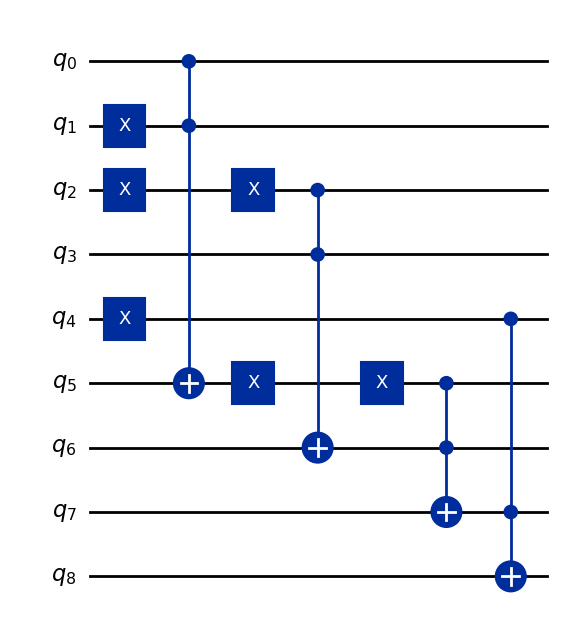

In [84]:
qc.draw(output='mpl')

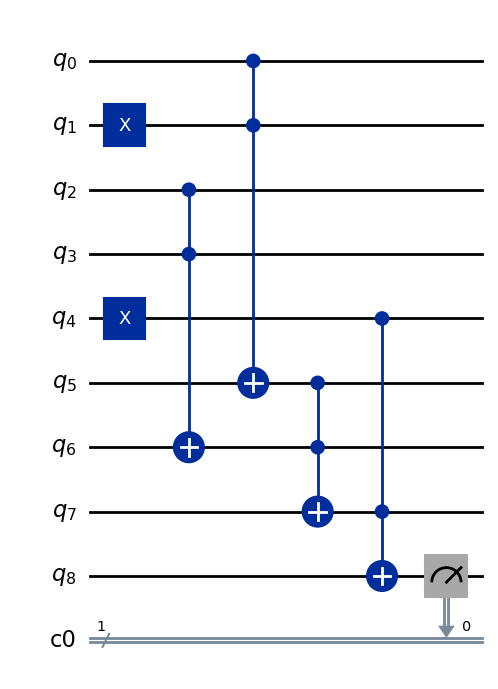

In [85]:
qc = transpile(qc, backend=AerSimulator(), optimization_level=2)
c = ClassicalRegister(1)
qc.add_register(c)
qc.measure(flag, c[0])
qc.draw(output='mpl')

In [87]:
print(expression)
print(testvec)
results = execute_qc(qc)
print(results)

! ( ! ( A & B ) ) & ( ! C & D ) & E
01101
{'0': 1024}
